# Load dependencies and tables

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Markdown as md

In [3]:
output_tables = "output_tables"
run_dir_name = "2024_11_18_16_07_output"
run_dir = os.path.join(output_tables, run_dir_name)

df_sample_mapping = pd.read_csv(os.path.join(output_tables, "sample_mapping.csv"))

df_filter_mapping_full = pd.read_csv(os.path.join(run_dir, "filter_mapping_full.csv"))
df_filter_mapping = pd.read_csv(os.path.join(run_dir, "filter_mapping.csv"))
df_truncate_mapping = pd.read_csv(os.path.join(run_dir, "truncate_mapping.csv"))

df_refseq_full = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_full.csv"))
df_refseq = pd.read_csv(os.path.join(run_dir, "refseq_table_pk.csv"))

df_refseq_srr_mapping_full = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr_full.csv"))
df_refseq_srr_mapping = pd.read_csv(os.path.join(run_dir, "mapping_table_pk_zotu_srr.csv"))

df_refseq_tax_full = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_full_tax.csv"))
df_refseq_tax = pd.read_csv(os.path.join(run_dir, "refseq_table_pk_tax.csv"))

In [4]:
# Merged table for analyzing results
df = df_sample_mapping.merge(df_truncate_mapping, on=["srr_name"], how="right")
df = df.merge(df_filter_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_filter_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}), on=["srr_name", "trunc_zotu_id"],
              suffixes=("_full", "_trunc"), how="left")
df = df.merge(df_refseq_srr_mapping_full, on=["srr_name", "zotu_id"], how="left")
df = df.merge(df_refseq_srr_mapping.rename(columns={"zotu_id": "trunc_zotu_id"}),
                                                        on=["srr_name", "trunc_zotu_id"], suffixes=("_full", "_trunc"), how="left")
df = df.merge(df_refseq_tax_full.rename(columns={"refsequence_pk": "refsequence_pk_full"}), on=["refsequence_pk_full"], how="left")
df = df.merge(df_refseq_tax.rename(
    columns={"refsequence_pk": "refsequence_pk_trunc"}),on=["refsequence_pk_trunc"], suffixes=("_full", "_trunc"), how="left")
df["tax_missing_full"] = df["UNITE_id_full"].isna()
df["tax_missing_trunc"] = df["UNITE_id_trunc"].isna()


display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65595 entries, 0 to 65594
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   srr_name              65595 non-null  object 
 1   plot                  65595 non-null  object 
 2   subplot               65588 non-null  float64
 3   location              65595 non-null  object 
 4   zotu_id               65595 non-null  object 
 5   trunc_zotu_id         64279 non-null  object 
 6   passed_trunc          65595 non-null  bool   
 7   passed_abun_full      65595 non-null  bool   
 8   passed_contam_full    65595 non-null  bool   
 9   passed_abun_trunc     64279 non-null  object 
 10  passed_contam_trunc   64279 non-null  object 
 11  refsequence_pk_full   6033 non-null   object 
 12  sequence_full         6033 non-null   object 
 13  refsequence_pk_trunc  6532 non-null   object 
 14  sequence_trunc        6532 non-null   object 
 15  identity_full      

None

# Filter results within samples

In [5]:
#Filter results on full length ZOTUs
df_filter_counts = pd.DataFrame.join(
    df.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True))
df_filter_counts.loc[(True,""),:] = df_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on full length ZOTUs"))
display(md(f"Of all {df.shape[0]} full length ZOTUs found across all samples:"))
display(df_filter_counts)

num_passed_abun = df_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter"))

## Filter results on full length ZOTUs

Of all 65595 full length ZOTUs found across all samples:

count  proportion
passed_abun_full passed_contam_full                     
False            False               59470.0    0.906624
True             True                 6033.0    0.091973
                 False                  92.0    0.001403
                                      6125.0    0.093376

- 6125.0 (9.34%) passed the abundance filter
- 6033.0 (9.20% of all, 98.50% of abundant) passed the contamination filter

In [6]:
# Truncation results on full length ZOTUs
df_trunc = df[df["passed_trunc"] == True]
df_trunc_derep = df_trunc.drop_duplicates(subset=['srr_name', 'trunc_zotu_id'])
df_trunc_counts = pd.DataFrame.join(
    df.value_counts(subset="passed_trunc"),
    df.value_counts(subset="passed_trunc", normalize=True))
df_trunc_counts = df_trunc_counts.join(
    df_trunc_derep.value_counts(subset="passed_trunc"), rsuffix=" derep")
display(md("## Truncation results on full length ZOTUs"))
display(md(f"Of all {df.shape[0]} full length ZOTUs found across all samples:"))
display(df_trunc_counts)

num_passed_trunc = df_trunc_counts.loc[True]['count']
prop_passed_trunc = df_trunc_counts.loc[True]['proportion']
num_not_passed_trunc = df_trunc_counts.loc[False]['count']
prop_not_passed_trunc = df_trunc_counts.loc[False]['proportion']
display(md(f"- {num_passed_trunc} ({prop_passed_trunc:.2%}) passed truncation\n"
           f"\t- {df_trunc_counts.loc[True]['count derep']} after dereplication within samples\n"
           f"- {num_not_passed_trunc} ({prop_not_passed_trunc:.2%}) did not pass truncation (<250bp) and are discarded"))

## Truncation results on full length ZOTUs

Of all 65595 full length ZOTUs found across all samples:

,count,proportion,count derep
passed_trunc,,,
True,64279,0.979937,61373.0
False,1316,0.020063,NaN


- 64279.0 (97.99%) passed truncation
	- 61373.0 after dereplication within samples
- 1316.0 (2.01%) did not pass truncation (<250bp) and are discarded

In [7]:
# Filter results on discarded ZOTUs
df_discard = df[df["passed_trunc"] == False]
df_discard_filter_counts = pd.DataFrame.join(
    df_discard.value_counts(subset=['passed_abun_full', 'passed_contam_full']),
    df_discard.value_counts(subset=['passed_abun_full', 'passed_contam_full'], normalize=True))
df_discard_filter_counts.loc[(True,""),:] = df_discard_filter_counts.loc[(True, slice(None))][['count', 'proportion']].sum()
display(md("## Filter results on discarded ZOTUs"))
display(md(f"Of the {df_discard.shape[0]} full length ZOTUs that do not pass truncation (<250bp):"))
display(df_discard_filter_counts)

num_passed_abun = df_discard_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_discard_filter_counts.loc[(True, '')]['proportion']
num_passed_contam = df_discard_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_discard_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) would have passed the abundance filter\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) would have passed the contamination filter"))

## Filter results on discarded ZOTUs

Of the 1316 full length ZOTUs that do not pass truncation (<250bp):

count  proportion
passed_abun_full passed_contam_full                    
False            False               1254.0    0.952888
True             True                  47.0    0.035714
                 False                 15.0    0.011398
                                       62.0    0.047112

- 62.0 (4.71%) would have passed the abundance filter
- 47.0 (3.57% of all, 75.81% of abundant) would have passed the contamination filter

In [8]:
# Filter results on truncated ZOTUs
df_trunc_filter_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True))
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc']), rsuffix=" derep")
df_trunc_filter_counts = df_trunc_filter_counts.join(
    df_trunc_derep.value_counts(subset=['passed_abun_trunc','passed_contam_trunc'], normalize=True), rsuffix=" derep")
df_trunc_filter_counts.loc[(True,""),:] = df_trunc_filter_counts.loc[(True, slice(None))][['count', 'proportion', 'count derep', 'proportion derep']].sum()
display(md("## Filter results on truncated ZOTUs"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_trunc_filter_counts)

num_passed_abun = df_trunc_filter_counts.loc[(True, '')]['count']
prop_passed_abun = df_trunc_filter_counts.loc[(True, '')]['proportion']
num_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['count derep']
prop_passed_abun_derep = df_trunc_filter_counts.loc[(True, '')]['proportion derep']
num_passed_contam = df_trunc_filter_counts.loc[(True, True)]['count']
prop_passed_contam = df_trunc_filter_counts.loc[(True, True)]['proportion']
prop_passed_contam_abun = prop_passed_contam / prop_passed_abun
num_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['count derep']
prop_passed_contam_derep = df_trunc_filter_counts.loc[(True, True)]['proportion derep']
prop_passed_contam_abun_derep = prop_passed_contam_derep / prop_passed_abun_derep
display(md(f"- {num_passed_abun} ({prop_passed_abun:.2%}) passed the abundance filter\n"
           f"\t- {num_passed_abun_derep} ({prop_passed_abun_derep:.2%}) after dereplication within samples\n"
           f"- {num_passed_contam} ({prop_passed_contam:.2%} of all, {prop_passed_contam_abun:.2%} of abundant) passed the contamination filter\n"
           f"\t- {num_passed_contam_derep} ({prop_passed_contam_derep:.2%} of all, {prop_passed_contam_abun_derep:.2%} of abundant) after dereplication within samples"))

## Filter results on truncated ZOTUs

Of all 64279 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

count  proportion  count derep  \
passed_abun_trunc passed_contam_trunc                                     
False             False                57652.0    0.896903      55247.0   
True              True                  6532.0    0.101620       6051.0   
                  False                   95.0    0.001478         75.0   
                                        6627.0    0.103097       6126.0   

                                       proportion derep  
passed_abun_trunc passed_contam_trunc                    
False             False                        0.900184  
True              True                         0.098594  
                  False                        0.001222  
                                               0.099816

- 6627.0 (10.31%) passed the abundance filter
	- 6126.0 (9.98%) after dereplication within samples
- 6532.0 (10.16% of all, 98.57% of abundant) passed the contamination filter
	- 6051.0 (9.86% of all, 98.78% of abundant) after dereplication within samples

In [9]:
# Comparing filter results before and after truncation
df_abun_compare_counts = pd.DataFrame.join(
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc']),
    df_trunc.value_counts(subset=['passed_abun_full', 'passed_abun_trunc', 'passed_contam_full', 'passed_contam_trunc'], normalize=True))
df_abun_compare_counts.loc[(True,True,"",""),:] = df_abun_compare_counts.loc[(True, True, slice(None), slice(None))][['count', 'proportion']].sum()
df_abun_compare_counts.loc[(False,True,"",""),:] = df_abun_compare_counts.loc[(False, True, slice(None), slice(None))][['count', 'proportion']].sum()
display(md("## Comparing filter results before and after truncation"))
display(md(f"Of all {df_trunc.shape[0]} truncated ZOTUs ({df_trunc_derep.shape[0]} after dereplication within samples) found across all samples:"))
display(df_abun_compare_counts)

num_passed_abun_both = df_abun_compare_counts.loc[(True, True, '', '')]['count']
num_passed_abun = df_abun_compare_counts.loc[(False, True, '', '')]['count']
num_passed_contam = df_abun_compare_counts.loc[(slice(None), slice(None), False, True)]['count'].sum()
display(md(f"- {num_passed_abun_both} passed the abundance filter both at full length and truncated\n"
           f"- {num_passed_abun} passed the abundance filter only when truncated\n"
           f"- {num_passed_contam} passed the contamination filter only when truncated\n (only because they would not have passed the abundance filter at full length)\n"
           "- None no longer pass the contamination filter after truncation when they would have passed at full length"))

df_abun_trunc_only = df[(df['passed_abun_full'] == False) & (df['passed_abun_trunc'] == True)]
df_abun_full_unique_trunc = df[df['passed_abun_full'] == True][['srr_name', 'trunc_zotu_id']].drop_duplicates()
df_abun_trunc_only = df_abun_trunc_only.merge(df_abun_full_unique_trunc,
                                on=['srr_name', 'trunc_zotu_id'], how='left', indicator=True).set_index(df_abun_trunc_only.index)
df_abun_trunc_only['new_zotu_trunc'] = df_abun_trunc_only['_merge'] == 'left_only'
df_abun_trunc_only = df_abun_trunc_only.drop(columns=['_merge'])
df_abun_trunc_only_counts = pd.DataFrame.join(
    df_abun_trunc_only.value_counts(subset=['new_zotu_trunc', 'passed_contam_trunc']),
    df_abun_trunc_only.drop_duplicates(subset=['srr_name', 'trunc_zotu_id']).value_counts(subset=['new_zotu_trunc', 'passed_contam_trunc']), rsuffix=" derep")
df_abun_trunc_only_counts.loc[(True,""),:] = df_abun_trunc_only_counts.loc[(True, slice(None))][['count', 'count derep']].sum()
display(md(f"Of the {num_passed_abun} truncated ZOTUs that passed the abundance filter only when truncated:"))
display(df_abun_trunc_only_counts)

num_abun_trunc_only = df_abun_trunc_only_counts.loc[(True,'')]['count']
num_abun_trunc_only_derep = df_abun_trunc_only_counts.loc[(True,'')]['count derep']
num_contam_trunc_only = df_abun_trunc_only_counts.loc[(True,True)]['count']
num_contam_trunc_only_derep = df_abun_trunc_only_counts.loc[(True,True)]['count derep']
display(md(f"- {num_abun_trunc_only} are \"new\", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length\n"
           f"\t- {num_abun_trunc_only_derep} after dereplication within samples\n"
           f"- {num_contam_trunc_only} are \"new\" and also pass the contamination filter\n"
           f"\t- {num_contam_trunc_only_derep} after dereplication within samples"))

## Comparing filter results before and after truncation

Of all 64279 truncated ZOTUs (61373 after dereplication within samples) found across all samples:

,,,,count,proportion
passed_abun_full,passed_abun_trunc,passed_contam_full,passed_contam_trunc,,
False,False,False,False,57652.0,0.896903
True,True,True,True,5986.0,0.093125
False,True,False,True,546.0,0.008494
True,True,False,False,77.0,0.001198
False,True,False,False,18.0,0.000280
True,True,,,6063.0,0.094323
False,True,,,564.0,0.008774


- 6063.0 passed the abundance filter both at full length and truncated
- 564.0 passed the abundance filter only when truncated
- 546.0 passed the contamination filter only when truncated
 (only because they would not have passed the abundance filter at full length)
- None no longer pass the contamination filter after truncation when they would have passed at full length

Of the 564.0 truncated ZOTUs that passed the abundance filter only when truncated:

count  count derep
new_zotu_trunc passed_contam_trunc                    
False          True                 317.0        252.0
True           True                 229.0        129.0
False          False                 14.0         10.0
True           False                  4.0          2.0
                                    233.0        131.0

- 233.0 are "new", meaning that truncated they are not equal to a ZOTU that also passed the abundance filter at full length
	- 131.0 after dereplication within samples
- 229.0 are "new" and also pass the contamination filter
	- 129.0 after dereplication within samples

# Reference table results

In [10]:
#Comparing reference sequences before and after truncation
num_ref_full = df_refseq_full.shape[0]
num_ref_trunc = df_refseq.shape[0]

display(md("## Comparing reference sequences before and after truncation"))
display(md(f"The number of reference sequences (unique ZOTUs across all samples) is:\n"
           f"- {num_ref_full} at full length\n"
           f"- {num_ref_trunc} when truncating"))

# ---

df_discard_contam_full = df_discard[df_discard["passed_contam_full"] == True]
df_discard_refseq_full = df_discard_contam_full.drop_duplicates(subset=["location", "refsequence_pk_full"]).copy()

df_discard_refseq_full["refseq_full_exclusive_to_loc"] = ~(
    df_discard_refseq_full["refsequence_pk_full"].isin(df_discard_refseq_full[df_discard_refseq_full["location"] == "A"]["refsequence_pk_full"]) &
    df_discard_refseq_full["refsequence_pk_full"].isin(df_discard_refseq_full[df_discard_refseq_full["location"] == "B"]["refsequence_pk_full"])
)

df_discard_refseq_full_count = pd.DataFrame(df_discard_refseq_full.value_counts(subset=["location", "refseq_full_exclusive_to_loc"]))

num_discard_contam_full = df_discard_contam_full.shape[0]
num_discard_refseq_full = df_discard_contam_full.drop_duplicates(subset="refsequence_pk_full").shape[0]
display(md(f"The {num_discard_contam_full} discarded ZOTUs that would have passed the contamination filter at full length include:"))
display(df_discard_refseq_full_count)
display(md(f"- {num_discard_refseq_full} reference sequences that are therefore not included after truncation\n"
           f"\t- None of them apear in both location A and B"))


#---

df_trunc_contam_full = df_trunc[df_trunc["passed_contam_full"] == True]
df_trunc_refseq_both = df_trunc_contam_full.drop_duplicates(subset=["location", "refsequence_pk_full", "refsequence_pk_trunc"]).copy()

df_trunc_refseq_both["refseq_full_exclusive_to_loc"] = ~(
    df_trunc_refseq_both["refsequence_pk_full"].isin(df_trunc_refseq_both[df_trunc_refseq_both["location"] == "A"]["refsequence_pk_full"]) &
    df_trunc_refseq_both["refsequence_pk_full"].isin(df_trunc_refseq_both[df_trunc_refseq_both["location"] == "B"]["refsequence_pk_full"]
))
df_trunc_refseq_both["refseq_trunc_exclusive_to_loc"] = ~(
    df_trunc_refseq_both["refsequence_pk_trunc"].isin(df_trunc_refseq_both[df_trunc_refseq_both["location"] == "A"]["refsequence_pk_trunc"]) &
    df_trunc_refseq_both["refsequence_pk_trunc"].isin(df_trunc_refseq_both[df_trunc_refseq_both["location"] == "B"]["refsequence_pk_trunc"]
))

df_trunc_refseq_both_count = pd.DataFrame.join(
    df_trunc_refseq_both.value_counts(subset=["location", "refseq_full_exclusive_to_loc", "refseq_trunc_exclusive_to_loc"]),
    df_trunc_refseq_both.drop_duplicates(subset=["location", "refsequence_pk_trunc"]).value_counts(subset=["location", "refseq_full_exclusive_to_loc", "refseq_trunc_exclusive_to_loc"]),
    lsuffix="_full", rsuffix="_trunc")

num_trunc_contam_full = df_trunc_contam_full.shape[0]
num_trunc_contam_full_trunc_derep = df_trunc_contam_full.drop_duplicates(subset=["srr_name", "trunc_zotu_id"]).shape[0]
num_trunc_refseq_full_exclusive_full = df_trunc_refseq_both_count.loc[(slice(None), True, slice(None))]["count_full"].sum()
num_trunc_refseq_both_exclusive_full = df_trunc_refseq_both_count.loc[(slice(None), True, True)]["count_full"].sum()
num_trunc_refseq_both_exclusive_trunc = df_trunc_refseq_both_count.loc[(slice(None), True, True)]["count_trunc"].sum()
num_trunc_refseq_full_exclusive_A_full = df_trunc_refseq_both_count.loc[("A", True, False)]["count_full"].sum()
num_trunc_refseq_full_exclusive_A_trunc = df_trunc_refseq_both_count.loc[("A", True, False)]["count_trunc"].sum()
num_trunc_refseq_full_exclusive_B_full = df_trunc_refseq_both_count.loc[("B", True, False)]["count_full"].sum()
num_trunc_refseq_full_exclusive_B_trunc = df_trunc_refseq_both_count.loc[("B", True, False)]["count_trunc"].sum()
num_trunc_refseq_not_exclusive_full = df_trunc_refseq_both_count.loc["A", False, slice(None)]["count_full"].sum()

display(md(f"The {num_trunc_contam_full} ZOTUs ({num_trunc_contam_full_trunc_derep} after dereplication within samples) that passed truncation and passed the contamination filter at full length (and therefore also after truncation as previously shown) include:"))
display(df_trunc_refseq_both_count)
display(md(f"- {num_trunc_refseq_full_exclusive_full} full length reference sequences that only appear in one location\n"
           f"\t- of which {num_trunc_refseq_both_exclusive_full} also only apear in one location after truncation\n"
           f"\t\t- resulting in {num_trunc_refseq_both_exclusive_trunc} truncated reference sequences\n"
           f"\t- of which {num_trunc_refseq_full_exclusive_A_full} are no longer exclusive to location A after truncation\n"
           f"\t\t- resulting in {num_trunc_refseq_full_exclusive_A_trunc} truncated reference sequences\n"
           f"\t- of which {num_trunc_refseq_full_exclusive_B_full} are no longer exclusive to location B after truncation\n"
           f"\t\t- resulting in {num_trunc_refseq_full_exclusive_B_trunc} truncated reference sequences\n"
           f"- {num_trunc_refseq_not_exclusive_full} full length reference sequences appear in both locations"
           ))


# ---

df_trunc_new_contam = df_abun_trunc_only[(df_abun_trunc_only["new_zotu_trunc"] == True) & (df_abun_trunc_only['passed_contam_trunc'] == True)]
df_trunc_refseq_new_zotu = df_trunc_new_contam.drop_duplicates(subset=["location", "refsequence_pk_trunc"])
df_trunc_refseq_both_trunc = df_trunc_refseq_both.drop_duplicates(subset=["location", "refsequence_pk_trunc"])

df_trunc_refseq_new_zotu= df_trunc_refseq_new_zotu.merge(
    df_trunc_refseq_both_trunc[["location", "refsequence_pk_trunc"]],
    on=["location", "refsequence_pk_trunc"], how="left", indicator=True).set_index(df_trunc_refseq_new_zotu.index)
df_trunc_refseq_new_zotu["new_refseq_trunc_within_loc"] = df_trunc_refseq_new_zotu["_merge"] == "left_only"
df_trunc_refseq_new_zotu = df_trunc_refseq_new_zotu.drop(columns=['_merge'])

df_trunc_refseq_new_zotu["new_refseq_trunc_outside_loc"] = ~(
    df_trunc_refseq_new_zotu["refsequence_pk_trunc"].isin(df_trunc_refseq_both_trunc["refsequence_pk_trunc"])
)

df_trunc_refseq_new_zotu_count = pd.DataFrame(df_trunc_refseq_new_zotu.value_counts(subset=["location", "new_refseq_trunc_within_loc", "new_refseq_trunc_outside_loc"]))

num_trunc_new_contam = df_trunc_new_contam.shape[0]
num_trunc_new_contam_derep = df_trunc_new_contam.drop_duplicates(subset=["srr_name", "trunc_zotu_id"]).shape[0]
num_trunc_refseq_new_zotu_not_new_refseq = df_trunc_refseq_new_zotu_count.loc[(slice(None), False, False)]["count"].sum()
num_trunc_refseq_new_zotu_new_refseq = df_trunc_refseq_new_zotu_count.loc[(slice(None), True, True)]["count"].sum()
num_trunc_refseq_new_zotu = num_trunc_refseq_new_zotu_not_new_refseq + num_trunc_refseq_new_zotu_new_refseq
num_trunc_refseq_new_zotu_newA = df_trunc_refseq_new_zotu_count.loc[("A", True, False)]["count"]
num_trunc_refseq_new_zotu_newB = df_trunc_refseq_new_zotu_count.loc[("B", True, False)]["count"]
display(md(f"The {num_trunc_new_contam} new ZOTUs ({num_trunc_new_contam_derep} after dereplication within samples) that passed the contamination filter after truncation include:"))
display(df_trunc_refseq_new_zotu_count)
display(md(f"- {num_trunc_refseq_new_zotu} reference sequences, of which {num_trunc_refseq_new_zotu_new_refseq} are only found among the new ZOTUs\n"
           f"\t- {num_trunc_refseq_new_zotu_newA} reference sequence is new among the ZOTUs in location A but not in B\n"
           f"\t- {num_trunc_refseq_new_zotu_newB} reference sequence is new among the ZOTUs in location B but not in A"))





## Comparing reference sequences before and after truncation

The number of reference sequences (unique ZOTUs across all samples) is:
- 1856 at full length
- 1767 when truncating

The 47 discarded ZOTUs that would have passed the contamination filter at full length include:

,,count
location,refseq_full_exclusive_to_loc,
A,True,25
B,True,6


- 31 reference sequences that are therefore not included after truncation
	- None of them apear in both location A and B

The 5986 ZOTUs (5922 after dereplication within samples) that passed truncation and passed the contamination filter at full length (and therefore also after truncation as previously shown) include:

count_full  \
location refseq_full_exclusive_to_loc refseq_trunc_exclusive_to_loc               
A        True                         True                                  971   
B        True                         True                                  789   
         False                        False                                  53   
A        False                        False                                  53   
B        True                         False                                   8   
A        True                         False                                   4   

                                                                     count_trunc  
location refseq_full_exclusive_to_loc refseq_trunc_exclusive_to_loc               
A        True                         True                                   934  
B        True                         True                                   750  
         False                        False                                   51  
A        False                        False                                   52  
B        True                         False                                    2  
A        True                         False                                    1

- 1772 full length reference sequences that only appear in one location
	- of which 1760 also only apear in one location after truncation
		- resulting in 1684 truncated reference sequences
	- of which 4 are no longer exclusive to location A after truncation
		- resulting in 1 truncated reference sequences
	- of which 8 are no longer exclusive to location B after truncation
		- resulting in 2 truncated reference sequences
- 53 full length reference sequences appear in both locations

The 229 new ZOTUs (129 after dereplication within samples) that passed the contamination filter after truncation include:

,,,count
location,new_refseq_trunc_within_loc,new_refseq_trunc_outside_loc,
A,False,False,50
B,False,False,22
A,True,True,21
B,True,True,9
A,True,False,1
B,True,False,1


- 102 reference sequences, of which 30 are only found among the new ZOTUs
	- 1 reference sequence is new among the ZOTUs in location A but not in B
	- 1 reference sequence is new among the ZOTUs in location B but not in A

# Taxonomy table results

In [31]:
#Taxonomic results on the discarded sequences
df_discard_refseq_full_tax_missing_count = pd.DataFrame(df_discard_refseq_full.value_counts(subset=["location", "refseq_full_exclusive_to_loc", "tax_missing_full"]))

df_discard_unite_full = df_discard_refseq_full[df_discard_refseq_full["tax_missing_full"] == False].drop_duplicates(subset=["location", "UNITE_id_full"])

df_trunc_unite_refseq_both = df_trunc_refseq_both[df_trunc_refseq_both["tax_missing_trunc"] == False].drop_duplicates(subset=["location", "UNITE_id_full", "UNITE_id_trunc"])
df_trunc_unite_refseq_both_full = df_trunc_unite_refseq_both.drop_duplicates(subset=["location", "UNITE_id_full"])
df_trunc_unite_refseq_both_trunc = df_trunc_unite_refseq_both.drop_duplicates(subset=["location", "UNITE_id_trunc"])

df_trunc_unite_new_refseq = df_trunc_refseq_new_zotu[
    (df_trunc_refseq_new_zotu["new_refseq_trunc_within_loc"] == True) & (df_trunc_refseq_new_zotu["tax_missing_trunc"] == True)].drop_duplicates(subset=["location", "UNITE_id_trunc"])

df_discard_unite_full = df_discard_unite_full.merge(
    df_trunc_unite_refseq_both_full[["location", "UNITE_id_full"]],
    on=["location","UNITE_id_full"], how="left", indicator=True).set_index(df_discard_unite_full.index)
df_discard_unite_full["UNITE_id_in_refseq_both_full"] = df_discard_unite_full["_merge"] == "both"
df_discard_unite_full = df_discard_unite_full.drop(columns=["_merge"])

df_discard_unite_full = df_discard_unite_full.merge(
    df_trunc_unite_refseq_both_trunc[["location", "UNITE_id_trunc"]].rename(columns={"UNITE_id_trunc": "UNITE_id_full"}),
    on=["location","UNITE_id_full"], how="left", indicator=True).set_index(df_discard_unite_full.index)
df_discard_unite_full["UNITE_id_in_refseq_both_trunc"] = df_discard_unite_full["_merge"] == "both"
df_discard_unite_full = df_discard_unite_full.drop(columns=["_merge"])

df_discard_unite_full = df_discard_unite_full.merge(
    df_trunc_unite_new_refseq[["location", "UNITE_id_trunc"]].rename(columns={"UNITE_id_trunc": "UNITE_id_full"}),
    on=["location","UNITE_id_full"], how="left", indicator=True).set_index(df_discard_unite_full.index)
df_discard_unite_full["UNITE_id_in_new_refseq"] = df_discard_unite_full["_merge"] == "both"
df_discard_unite_full = df_discard_unite_full.drop(columns=["_merge"])

df_discard_unite_full_counts = pd.DataFrame(df_discard_unite_full.value_counts(
    subset=["location", "UNITE_id_in_refseq_both_full", "UNITE_id_in_refseq_both_trunc", "UNITE_id_in_new_refseq"]))

num_discard_refseq_full_unite_na = df_discard_refseq_full[df_discard_refseq_full["tax_missing_full"] == True].shape[0]
num_discard_refseq_full_unite = df_discard_refseq_full[df_discard_refseq_full["tax_missing_full"] == False].shape[0]
num_discard_unite_full = df_discard_unite_full.shape[0]
num_discard_unite_full_not_elsewhere = df_discard_unite_full_counts.loc[(slice(None), slice(None), False, False)]["count"].sum()
display(md(f"Of the {num_discard_refseq_full} discarded reference sequences:"))
display(df_discard_refseq_full_tax_missing_count)
display(md(f"- {num_discard_refseq_full_unite_na} did not have a UNITE hit"))
display(df_discard_unite_full_counts)
display(md(f"- The remaining {num_discard_refseq_full_unite} map to {num_discard_unite_full} unique UNITE hits within locations\n"
           f"\t- {num_discard_unite_full_not_elsewhere} of these hits are no longer present within locations after truncating"))

df_discard_unite_full_elsewhere = df_discard_unite_full[
    (df_discard_unite_full["UNITE_id_in_refseq_both_trunc"] == False) & (df_discard_unite_full["UNITE_id_in_new_refseq"] == False)]
df_discard_unite_full_elsewhere_tax_count = pd.DataFrame(df_discard_unite_full_elsewhere.value_counts(subset="phylum_full"))
display(df_discard_unite_full_elsewhere_tax_count)


#Taxonomic differences on ZOTUs that pass at full length and after truncation

df_trunc_refseq_full_loc_tax_missing_count = pd.DataFrame(df_trunc_refseq_full_loc.value_counts(subset=["location", "exclusive_to_loc", "tax_missing_full", "tax_missing_trunc"]))
display(df_trunc_refseq_full_loc_tax_missing_count)

df_trunc_unite_full_new = df_trunc_refseq_full_loc[df_trunc_refseq_full_loc["tax_missing_full"] != df_trunc_refseq_full_loc["tax_missing_trunc"]].drop_duplicates(subset=["location", "UNITE_id_trunc"])

df_trunc_unite_full_new["UNITE_id_in_trunc"] = df_trunc_unite_full_new["UNITE_id_trunc"].isin(df_trunc_refseq_full_loc[df_trunc_refseq_full_loc["tax_missing_full"] == False]["UNITE_id_trunc"])
df_trunc_unite_full_new["UNITE_id_in_full"] = df_trunc_unite_full_new["UNITE_id_trunc"].isin(df_trunc_refseq_full_loc[df_trunc_refseq_full_loc["tax_missing_full"] == False]["UNITE_id_full"])

display(df_trunc_unite_full_new[["location", "UNITE_id_trunc", "UNITE_id_in_trunc", "UNITE_id_in_full"]])

df_trunc_unite_full_both = df_trunc_refseq_full_loc[(df_trunc_refseq_full_loc["tax_missing_full"] == False) & (df_trunc_refseq_full_loc["tax_missing_trunc"] == False)]
df_trunc_unite_full_both["UNITE_id_equal"] = df_trunc_unite_full_both["UNITE_id_full"] == df_trunc_unite_full_both["UNITE_id_trunc"]

display(pd.DataFrame.join(df_trunc_unite_full_both.value_counts(subset=["location", "exclusive_to_loc", "UNITE_id_equal"]),
                          df_trunc_unite_full_both.drop_duplicates(subset=["location", "UNITE_id_full", "UNITE_id_trunc"]).value_counts(subset=["location", "exclusive_to_loc", "UNITE_id_equal"]), lsuffix="_refseq", rsuffix="_UNITE_id"))

levels = ["phylum", "class", "order", "family", "genus", "species"]
for level in levels:
    df_trunc_unite_full_both[f"{level}_equal"] = df_trunc_unite_full_both[f"{level}_full"] == df_trunc_unite_full_both[f"{level}_trunc"]

df_trunc_unite_full_both_not_equal_count = pd.DataFrame(df_trunc_unite_full_both[df_trunc_unite_full_both["UNITE_id_equal"] == False].value_counts(subset=[f"{level}_equal" for level in levels]))
display(df_trunc_unite_full_both_not_equal_count)



Of the 31 discarded reference sequences:

count
location refseq_full_exclusive_to_loc tax_missing_full       
A        True                         False                19
                                      True                  6
B        True                         True                  4
                                      False                 2

- 10 did not have a UNITE hit

count
location UNITE_id_in_refseq_both_full UNITE_id_in_refseq_both_trunc UNITE_id_in_new_refseq       
A        False                        False                         False                      13
         True                         True                          False                       1
B        False                        False                         False                       1

- The remaining 21 map to 15 unique UNITE hits within locations
	- 14 of these hits are no longer present within locations after truncating

,count
phylum_full,
Rozellomycota,7
Fungi_phy_Incertae_sedis,4
Ascomycota,3


NameError: name 'df_trunc_refseq_full_loc' is not defined

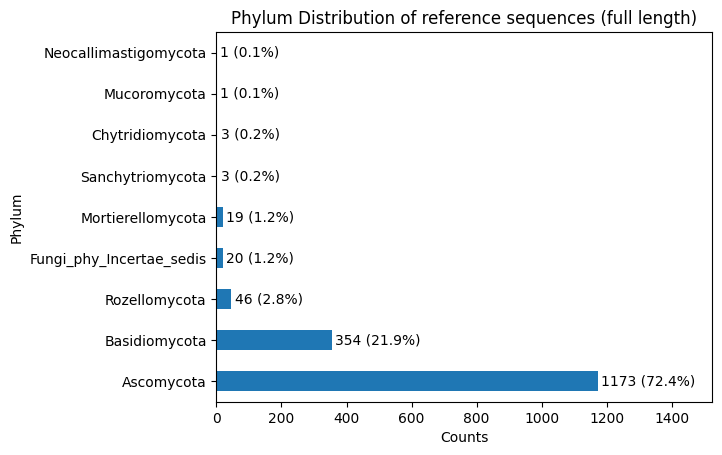

In [ ]:
value_counts = df_refseq_tax_full["phylum"].value_counts()
proportions = value_counts / value_counts.sum()
ax = value_counts.plot.barh(xlim=(0, value_counts.max() * 1.3))

for index, (count, proportion) in enumerate(zip(value_counts, proportions)):
    ax.text(count + 10, index, f"{count} ({proportion:.1%})", va='center')

ax.set_xlabel("Counts")
ax.set_ylabel("Phylum")
ax.set_title("Phylum Distribution of reference sequences (full length)")

plt.show()

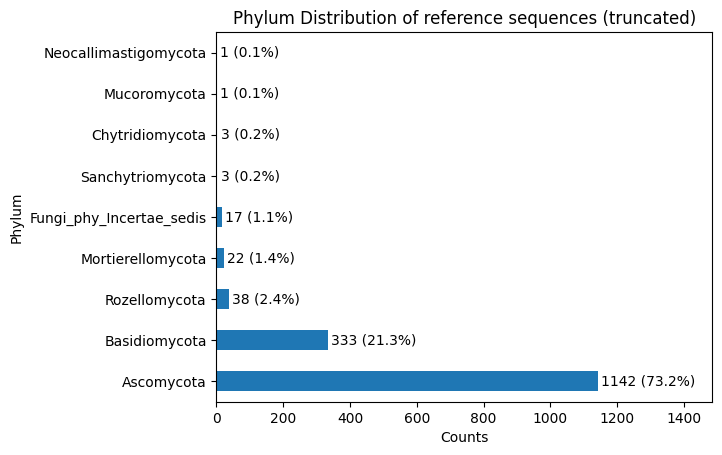

In [ ]:
value_counts = df_refseq_tax["phylum"].value_counts()
proportions = value_counts / value_counts.sum()
ax = value_counts.plot.barh(xlim=(0, value_counts.max() * 1.3))

for index, (count, proportion) in enumerate(zip(value_counts, proportions)):
    ax.text(count + 10, index, f"{count} ({proportion:.1%})", va='center')

ax.set_xlabel("Counts")
ax.set_ylabel("Phylum")
ax.set_title("Phylum Distribution of reference sequences (truncated)")

plt.show()

# Full length reference table

## Sequence length of reference ZOTUs

,refseq_length
count,1856.000000
mean,322.687500
std,35.298212
min,204.000000
25%,298.750000
50%,312.000000
75%,342.000000
max,478.000000


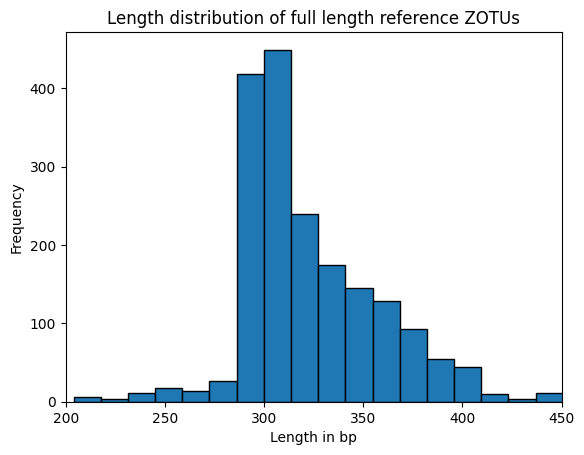

In [ ]:
# Length of full length reference ZOTUs
display(md("## Sequence length of reference ZOTUs"))
display(df_refseq_full.describe())
ax = df_refseq_full['refseq_length'].plot.hist(bins=20, xlim=(200, 450), edgecolor = "black")
ax.set_title("Length distribution of full length reference ZOTUs")
ax.set_xlabel("Length in bp")

plt.show()
